In [58]:
import pandas as pd

In [59]:
# Load the Excel file
file_path = '../compile/compiled_data_normalized_ver2.xlsx'
data = pd.read_excel(file_path)

# Extract relevant columns
years = data['Tahun']
poverty_percentage = data['Persentase Kemiskinan']

In [60]:
poverty_percentage[:-1]

0     13.11
1     11.51
2     10.75
3     10.58
4      9.87
5     10.09
6     10.10
7      9.90
8      7.94
9      7.94
10     8.14
11     8.60
12     7.90
13     7.30
Name: Persentase Kemiskinan, dtype: float64

In [61]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(poverty_percentage[:-1])

(0.2046683659773909, True)

In [62]:
# Define training and testing sets
train_size = len(poverty_percentage) - 3
train, test = poverty_percentage[:train_size], poverty_percentage[train_size:]

In [63]:
from pmdarima import auto_arima

# Fit the Auto ARIMA model
# Membuat model Auto ARIMA dengan parameter kompleks
model = auto_arima(
    train,
    start_p=0,
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    start_P=0,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    error_action='warn',
    trace=True,  # Menampilkan proses fitting model
    suppress_warnings=True,
    stepwise=True,  # Menggunakan pencarian stepwise untuk mempercepat proses pencarian model terbaik
    random_state=20,  # Mengatur seed untuk reproduktifitas
    n_fits=50  # Menentukan jumlah maksimum model yang akan dicoba
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.555, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.530, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30.511, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.509, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32.490, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.379 seconds


In [70]:
# Forecast the next 3 data points
forecast = model.predict(n_periods=3)

In [65]:
forecast

12    8.19
13    7.78
14    7.37
15    6.96
dtype: float64

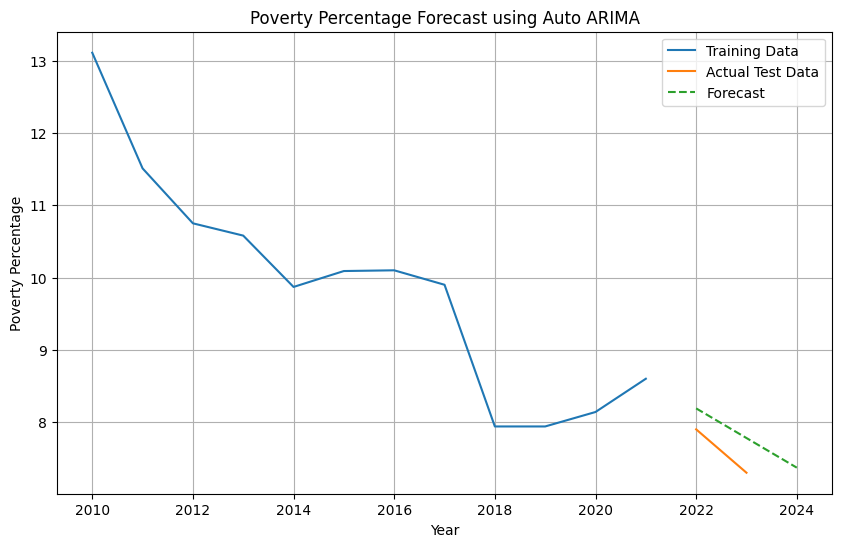

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(years[:train_size], train, label='Training Data')
plt.plot(years[train_size:], test, label='Actual Test Data')
plt.plot(years[train_size:], forecast, label='Forecast', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Poverty Percentage')
plt.title('Poverty Percentage Forecast using Auto ARIMA')
plt.legend()
plt.grid(True)
plt.show()


## ARIMAX

In [38]:
# Defining the exogenous variables (excluding 'Persentase Kemiskinan' and 'Tahun')
exogenous_vars = data.drop(columns=['Persentase Kemiskinan', 'Tahun'])

In [39]:
exog_train, exog_test = exogenous_vars[:train_size], exogenous_vars[train_size:]

In [74]:
# Fit the Auto ARIMAX model with exogenous variables
model_arimax = auto_arima(
    train,
    exogenous=exog_train # Pass exogenous variables for ARIMAX
# Limit maximum number of models to try
)

model_arimax.fit(train,exogenous=exog_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [80]:
# Forecast the next 3 data points
forecast_arimax = model_arimax.predict(n_periods=3, exogenous=exog_test) 

In [81]:
forecast_arimax

12    8.19
13    7.78
14    7.37
dtype: float64

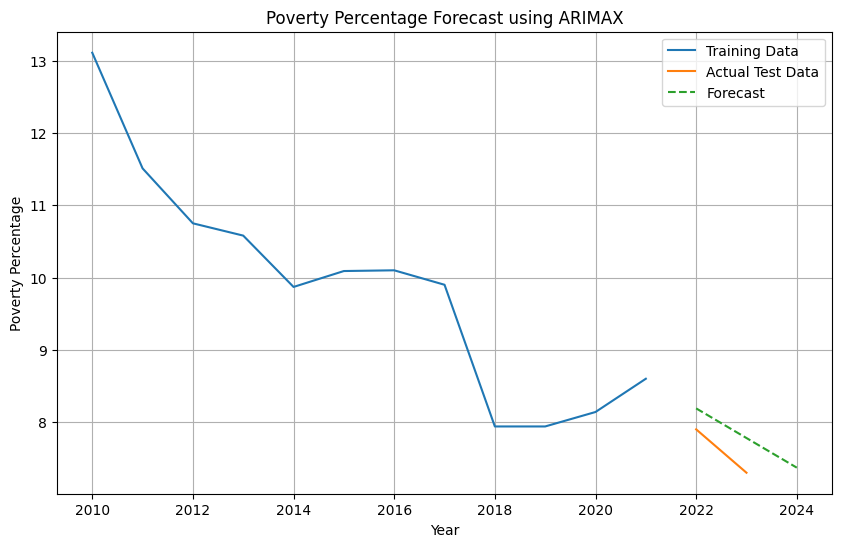

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(years[:train_size], train, label='Training Data')
plt.plot(years[train_size:], test, label='Actual Test Data')
plt.plot(years[train_size:], forecast_arimax, label='Forecast', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Poverty Percentage')
plt.title('Poverty Percentage Forecast using ARIMAX')
plt.legend()
plt.grid(True)
plt.show()

## Model

In [83]:
import joblib

# Menyimpan model
joblib.dump(model_arimax, 'model_arimax.joblib')

['model_arimax.joblib']

In [6]:
import numpy as np
import joblib
import pandas as pd

def predict_arimax(query):
    # Memuat model
    model = joblib.load('model_arimax.joblib')
    
    # Mengubah query menjadi array numpy
    exog = np.array(query).reshape(1, -1)
    
    # Melakukan prediksi
    forecast = model.predict(n_periods=1, exogenous=exog)
    
    # Menangani berbagai kemungkinan output
    if isinstance(forecast, pd.Series):
        return forecast.iloc[0]
    elif isinstance(forecast, np.ndarray):
        return forecast[0]
    elif isinstance(forecast, (float, int)):
        return forecast
    else:
        raise ValueError(f"Unexpected forecast type: {type(forecast)}")

In [13]:
query = [18.22, 5.47, 3.19, 4.78, 22.78, 15.95, 6.83, 22.78]
predict_arimax(query)

8.189999999965762